# Policy Gradient

This code is an example using Policy Gradient Method. The code is from [this website](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63).
The example uses the gym [CartPole system](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).
Here we use [pyTorch](https://pytorch.org/) rather than [tensorFlow](https://www.tensorflow.org/). 
- `torch.nn` is used to inherit and use the neural network class.
- `torch.nn.functional` is used to apply ReLU or softmax.
- `torch.optim` is used to apply [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/), a famous method for stochastic gradient descent.
- `torch.autograd`'s `Variable` is known to be deprecated [[REF]](https://stackoverflow.com/questions/57580202/whats-the-purpose-of-torch-autograd-variable), but since the original code uses it we will leave it as it is.

In [3]:
import sys
import gym
import numpy as np  

import torch  
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from   torch.autograd import Variable

import matplotlib.pyplot   as plt


# Defining a Policy Network

The policy neural network has three layers:
- [Layer 1] Denoted as $l_1$ with $n_s$ Neurons. The input is the state of the current cart-and-pole.
- [Layer 2] Denoted as $l_2$ with $n_{h}$ Neurons, where subscript $h$ stands for "hidden".
- [Layer 3] Denoted as $l_3$ with $n_a$ Neurons

From $l_1$ to $l_2$ and $l_2$ to $l_3$, the network uses a linear combination, i.e., using $l_1$, $l_2$ and $l_3$ as an array of values of the corresponding neurons:
$$
\begin{align*}
    l_2 &= W_{12} \cdot l_1 + b_{12} \\
    l_3 &= W_{23} \cdot l_2 + b_{23}
\end{align*}    
$$
where $W$ and $b$ are weight matrix and bias array, respectively.
Note that the values are additionally fed into a nonlinear function.
$l_2$ is fed into a ReLU (Rectified Linear Unit) function, and $l_3$ is fed into a softmax function to make it as a probability distribution function (i.e., all the values are non-negative and it sums to 1)

In [4]:

class PolicyNetwork( nn.Module ):
    def __init__( self, num_inputs, num_actions, hidden_size, learning_rate = 3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1     = nn.Linear( num_inputs, hidden_size  )
        self.linear2     = nn.Linear( hidden_size, num_actions )
        self.optimizer   = optim.Adam( self.parameters(), lr = learning_rate )

    def forward(self, state):
        x = F.relu( self.linear1( state ) )
        x = F.softmax( self.linear2( x ), dim=1)
        return x 
    
    def get_action( self, state ):
        state = torch.from_numpy( state ).float().unsqueeze( 0 )

        # Forward the neural network and return the prbability distribution function
        probs = self.forward( Variable( state ) )

        # Choosing the action based on the output policy
        highest_prob_action = np.random.choice( self.num_actions, p = np.squeeze( probs.detach( ).numpy( ) ) )

        # The log-value of the probability just for the sake of policy gradient
        log_prob            = torch.log( probs.squeeze( 0 )[ highest_prob_action ] )
        return highest_prob_action, log_prob


# Policy update via Gradient

Since we parameterized the policy as a neural network, the map from state to action is now parameterized and therefore the gradient can be calculated. We denote the parameterized policy as $\pi_{\theta}(a|s)$, where $\theta$ stands for the weights and biases of the 3-layer neural network.


 
The policy gradient formula is as follows:
$$
    \Delta_\theta J(\theta) = \sum_{t=0}^{T-1} \Delta_{\theta} \log \pi_{\theta} (a_t | s_t) G_t
$$
where $G_t$ is a discounted reward:
$$
    G_t = \mathbb{E}[R_{t+1}+\gamma R_{t+2}+\cdots | S_t = s]
$$
This method is called the REINFORCE algorithm, which is a Monte-Carlo variant of policy gradients. Note that Monte-Carlo methods is simply a hard way of saying "methods using random samples".
The Monte-Carlo method is required since we cannot calculate actual "expectations" in real life $\mathbb{E}[\cdot]$. We need to somehow take samples and average it to calculate the expectations. 

In [5]:

def update_policy( policy_network, rewards, log_probs ):

    # This is the discount rate, it should be smaller than 1 for convergence. 
    GAMMA = 0.9

    discounted_rewards = [ ]

    # Given the trajectory (or arrays) of rewards, we calculate the discounted reward. 
    for t in range( len( rewards ) ) :

        # Initialization of Gt
        Gt = 0 

        # The power for the calculation
        pw = 0
        
        for r in rewards[ t: ] :
            Gt += GAMMA ** pw * r
            pw += + 1
        discounted_rewards.append( Gt )
        
    discounted_rewards = torch.tensor( discounted_rewards )
    discounted_rewards = ( discounted_rewards - discounted_rewards.mean( ) ) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = [ ]

    for log_prob, Gt in zip( log_probs, discounted_rewards ):
        policy_gradient.append( -log_prob * Gt )
    
    # Initialization of the gradient value
    policy_network.optimizer.zero_grad( )
    
    policy_gradient = torch.stack( policy_gradient ).sum( )

    # Backpropagation (or simply, chain rule!)
    policy_gradient.backward( )
    policy_network.optimizer.step()        



# A bit more Explanation

### Part 1 - The discount rate
In the code, `GAMMA` variable is a discount rate $\gamma$. Recall that $G_t$ is:
$$
    G_t = \mathbb{E}[R_{t+1}+\gamma R_{t+2}+\cdots | S_t = s]
$$ 
Choosing $\gamma \in [0, 1)$ is necessary for the iteration to converge. The convergence proof uses "contraction" of mapping, and $\gamma$ being smaller than 1 is crucial for the proof. For people who are interested, this simplified proof for Q-learning might be useful [[REF]](http://users.isr.ist.utl.pt/~mtjspaan/readingGroup/ProofQlearning.pdf).



### Part 2 - Trajectory 
For each trial, we get a sequence of:
$$
    S_0, A_0, R_1, S_1, A_1, \cdots, S_{T-1}, A_{T-1}, R_T, S_T
$$
where $T$ is the final time-step of the simulation. From this, we iteratively calculate $G_t$ for $t\in \{ 1,2, \cdots, T\}$. 
$$
    G_t = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{T-t-1} R_{T}
$$
Note that the expectation operator is dropped off since we are approximating it with Monte-Carlo Method.

### Part 3 - Normalization of $G_t$?
This is the (personally) most confusing part, but I believe it is due to some practical reason. 
```
    discounted_rewards = ( discounted_rewards - discounted_rewards.mean( ) ) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards
```
[This post](https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem) will be helpful. 
The bottom line is to simply stabilize the learning process by normalization, which keeps the $G_t$ value in some reasonable value range.

# Example - Cart-and-Pole System

The 

episode: 0, total reward: 64.0, average_reward: 64.0, length: 63
episode: 1, total reward: 21.0, average_reward: 42.5, length: 20
episode: 2, total reward: 44.0, average_reward: 43.0, length: 43
episode: 3, total reward: 23.0, average_reward: 38.0, length: 22
episode: 4, total reward: 23.0, average_reward: 35.0, length: 22
episode: 5, total reward: 37.0, average_reward: 35.333, length: 36
episode: 6, total reward: 34.0, average_reward: 35.143, length: 33
episode: 7, total reward: 15.0, average_reward: 32.625, length: 14
episode: 8, total reward: 14.0, average_reward: 30.556, length: 13
episode: 9, total reward: 24.0, average_reward: 29.9, length: 23
episode: 10, total reward: 46.0, average_reward: 28.1, length: 45
episode: 11, total reward: 12.0, average_reward: 27.2, length: 11
episode: 12, total reward: 24.0, average_reward: 25.2, length: 23
episode: 13, total reward: 22.0, average_reward: 25.1, length: 21
episode: 14, total reward: 9.0, average_reward: 23.7, length: 8
episode: 15, t

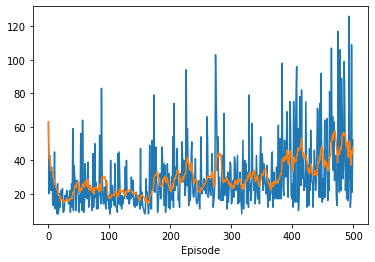

In [6]:

# Generate the gym of Cart-and-Pole
env = gym.make( 'CartPole-v1' )

# The number of states and actions are +4 and +2
ns  = env.observation_space.shape[ 0 ]
na  = env.action_space.n

# Generate the 3-layer Policy Network.
policy_net = PolicyNetwork( ns, na, 128 ) 

# We conduct max_episode_num trails (or episodes)
max_episode_num = 500

# For each trial, we run (e.g.,) 1000 steps, i.e., T = 1000 and the trajectory will be as follows:
# S0, A0, R1, S1, A1, ... S999 A999 R1000, S1000
# .... in case if the simulation does not reach the terminal state
max_steps       = 2000

# Saving the number of steps for each trial
numsteps        = []
avg_numsteps    = []

# Saving the sum of rewards of a single trial
all_rewards     = []

for episode in range( max_episode_num ):

    # gym initialization
    state     = env.reset()

    # To run gradient ascent, we need to save the array of log_probs and rewards. 
    # In detail, it is the "discounted" rewards, but the "update_policy" method executes that calculation internally. 
    log_probs = []
    rewards   = []

    # Run a single trial
    for steps in range( max_steps ):

        env.render( )

        # Get the choice of action and the pi( a_t | s_t ) for the gradient calculation
        action, log_prob = policy_net.get_action( state )

        # The 4th argument is "info", which is some sort of additional information that we don't use for this example.
        new_state, reward, done, _ = env.step( action )

        log_probs.append( log_prob )
        rewards.append( reward )

        # If the trail encounters the terminal state
        if done: 
            update_policy( policy_net, rewards, log_probs )

            numsteps.append( steps )

            # Taking the average of the number of steps for the learning process
            avg_numsteps.append( np.mean( numsteps[ -10: ] ) )

            # The rewards of the whole process. 
            all_rewards.append( np.sum( rewards ))


            if episode % 1 == 0:
                sys.stdout.write( "episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break
        
        state = new_state
    

plt.plot( numsteps )
plt.plot( avg_numsteps )
plt.xlabel('Episode')
plt.show()

# Run the optimal policy (i.e., optimal neural network)


# References 

- [1] [Great post on Github](https://github.com/dennybritz/reinforcement-learning/blob/master/PolicyGradient/README.md)
- [2] [Policy Gradient with Stephan Curry](https://jonathan-hui.medium.com/rl-policy-gradients-explained-9b13b688b146)
- [3] [Policy Gradient in a Nutshell](https://towardsdatascience.com/policy-gradients-in-a-nutshell-8b72f9743c5d)
- [4] 